In [21]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from datasets.SP100Stocks import SP100Stocks
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader
from tqdm import trange

In [22]:
%load_ext tensorboard
%tensorboard --logdir runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Launching TensorBoard...

# Stock Variations Forecasting
The goal of this task is to predict the variation at the timestep $t+1$ for each stock in the S&P 100 index. The variation is defined as the percentage change in the stock price from the previous timestep. For this task, a Temporal Graph Convolutional Network ([T-GCN: A Temporal Graph Convolutional Network for Traffic Prediction](https://arxiv.org/pdf/1811.05320)) is used. It consists of a GCN encoder followed by a GRU decoder. The encoder is used to learn the representation of the graph at each timestep, while the decoder is used to predict the variation at the next timestep.

## Loading the data
The data from the custom PyG dataset for forecasting is loaded into a PyTorch dataloader.

In [23]:
dataset = SP100Stocks()
dataset, dataset[0]

(SP100Stocks(1209),
 Data(x=[100, 7, 25], edge_index=[2, 2460], y=[100, 1], edge_weight=[2460], close_price=[100, 25], close_price_y=[100, 1]))

In [24]:
train_part = .9
batch_size = 64

train_dataset, test_dataset = dataset[:int(train_part * len(dataset))], dataset[int(train_part * len(dataset)):]
print(f"Train dataset: {len(train_dataset)}, Test dataset: {len(test_dataset)}")
train_dataloader, test_dataloader = DataLoader(train_dataset, batch_size=batch_size), DataLoader(test_dataset, batch_size=batch_size // 4, drop_last=True)

Train dataset: 1088, Test dataset: 121


## Temporal Graph Convolutional Network Model
The TGCN from the paper is implemented using PyTorch. The model encodes the graph nodes with a two-layer GCN, and then decodes the hidden state with a GRU.

In [25]:
class GCN(nn.Module):
	"""
	Simple two layers GCN model.
	"""
	def __init__(self, in_channels: int, hidden_size: int):
		super(GCN, self).__init__()
		self.conv1 = GCNConv(in_channels, hidden_size)
		self.conv2 = GCNConv(hidden_size, hidden_size)
			
	def forward(self, x: torch.tensor, edge_index: torch.tensor, edge_weight: torch.tensor) -> torch.tensor:
		x = F.relu(self.conv1(x, edge_index, edge_weight))
		return self.conv2(x, edge_index, edge_weight)

In [26]:
class TGCNCell(nn.Module):
	"""
	T-GCN Cell for one timestep, from https://arxiv.org/pdf/1811.05320.
	"""
	def __init__(self, in_channels: int, hidden_size: int):
		super(TGCNCell, self).__init__()
		self.gcn = GCN(in_channels, hidden_size)
		self.lin_u = nn.Linear(2 * hidden_size, hidden_size)
		self.lin_r = nn.Linear(2 * hidden_size, hidden_size)
		self.lin_c = nn.Linear(2 * hidden_size, hidden_size)
		
	def forward(self, x: torch.tensor, edge_index: torch.tensor, edge_weight: torch.tensor, h: torch.tensor) -> tuple[torch.tensor, torch.tensor]:
		"""
		Performs a forward pass on a single TGCN cell (GCN + GRU).
		:param x: The feature matrix of the graph X_t (Nodes_nb, Features_nb)
		:param edge_index: The edge index of the graph A (2, Edges_nb) 
		:param edge_weight: The edge weight of the graph (Edges_nb,)
		:param h: The hidden state of the GRU h_{t-1} (Nodes_nb, Hidden_size)
		:return: The hidden state of the GRU h_t (Nodes_nb, Hidden_size)
		"""
		x = F.sigmoid(self.gcn(x, edge_index, edge_weight))  # f(A,X_t), Eq. 2
		u = F.sigmoid(self.lin_u(torch.cat([x, h], dim=-1)))  # u_t, Eq. 3
		r = F.sigmoid(self.lin_r(torch.cat([x, h], dim=-1)))  # r_t,  Eq. 4
		c = F.tanh(self.lin_c(torch.cat([x, r * h], dim=-1)))  # c_t, Eq. 5

		return u * h + (1 - u) * c  # h_t, Eq. 6

In [27]:
class TGCN(nn.Module):
	"""
	T-GCN model from https://arxiv.org/pdf/1811.05320.
	"""
	def __init__(self, in_channels: int, out_channels: int, hidden_size: int):
		super(TGCN, self).__init__()
		self.hidden_size = hidden_size
		self.cell = TGCNCell(in_channels, hidden_size)
		self.out = nn.Linear(hidden_size, out_channels)
		
	def forward(self, x: torch.tensor, edge_index: torch.tensor, edge_weight: torch.tensor) -> torch.tensor:
		"""
		Performs a forward pass on the TGCN model.
		:param x: The feature matrix of the graph X_t (Nodes_nb, Features_nb, SeqLength)
		:param edge_index: The edge index of the graph A (2, Edges_nb) 
		:param edge_weight: The edge weight of the graph (Edges_nb,)
		:return: The hidden state of the GRU h_t (Nodes_nb, Hidden_size)
		"""
		h = torch.zeros(x.shape[0], self.hidden_size)
		for t in range(x.shape[-1]):
			h = self.cell(x[:, :, t], edge_index, edge_weight, h)
		return self.out(h)

## Training
The model is trained using the training dataset and the Adam optimizer. The `weight_decay` parameter is used for L2 regularization, to follow the paper methodology. The loss is calculated using the Mean Squared Error (MSE) loss function.

In [28]:
def train(model: nn.Module, optimizer: optim.Optimizer, criterion: nn.Module, train_dataloader: DataLoader, test_dataloader: DataLoader, num_epochs: int) -> tuple[list, list]:
	writer = SummaryWriter(f'runs/PriceForecasting_{datetime.now().strftime("%d_%m_%Hh%M")}')
	for epoch in (pbar := trange(num_epochs, desc="Epochs")):
		for idx, data in enumerate(train_dataloader):
			optimizer.zero_grad()
			out = model(data.x, data.edge_index, data.edge_weight)
			loss = criterion(out, data.y)
			loss.backward()
			optimizer.step()
			pbar.set_postfix({"Loss": loss.item(), "Batch": f"{idx / len(train_dataloader) * 100:.1f}%"})
			writer.add_scalar("Loss/Train Loss", loss.item(), epoch * len(train_dataloader) + idx)
		for idx, data in enumerate(test_dataloader):
			out = model(data.x, data.edge_index, data.edge_weight)
			loss = criterion(out, data.y)
			writer.add_scalar("Loss/Test Loss", loss.item(), epoch * len(test_dataloader) + idx)

In [29]:
in_channels, out_channels, hidden_size = dataset[0].x.shape[-2], 1, 32
model = TGCN(in_channels, out_channels, hidden_size)
model

TGCN(
  (cell): TGCNCell(
    (gcn): GCN(
      (conv1): GCNConv(7, 32)
      (conv2): GCNConv(32, 32)
    )
    (lin_u): Linear(in_features=64, out_features=32, bias=True)
    (lin_r): Linear(in_features=64, out_features=32, bias=True)
    (lin_c): Linear(in_features=64, out_features=32, bias=True)
  )
  (out): Linear(in_features=32, out_features=1, bias=True)
)

In [30]:
lr, weight_decay, num_epochs = 0.005, 1e-5, 12

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [31]:
train(model, optimizer, criterion, train_dataloader, test_dataloader, num_epochs)

Epochs: 100%|██████████| 12/12 [09:23<00:00, 46.99s/it, Loss=0.55, Batch=94.1%] 


## Results
The model tries to forecast the variations one timestep ahead for four stocks. The real values are plotted against the forecasted values.

### Results on train data

In [32]:
train_predictions = np.array([
	model(g.x, g.edge_index, g.edge_weight).detach().numpy() for g in train_dataloader
]).reshape((len(train_dataloader) * train_dataloader.batch_size, -1))
train_targets = np.array([g.y.numpy() for g in train_dataloader]).reshape((len(train_dataloader) * train_dataloader.batch_size, -1))

MSE = np.mean((train_predictions - train_targets) ** 2)
RMSE = np.sqrt(MSE)
MAE = np.mean(np.abs(train_predictions - train_targets))

print(f"Mean Squared Error: {MSE:.4f}, Root Mean Squared Error: {RMSE:.4f}, Mean Absolute Error: {MAE:.4f}")

Mean Squared Error: 0.4184, Root Mean Squared Error: 0.6469, Mean Absolute Error: 0.4842


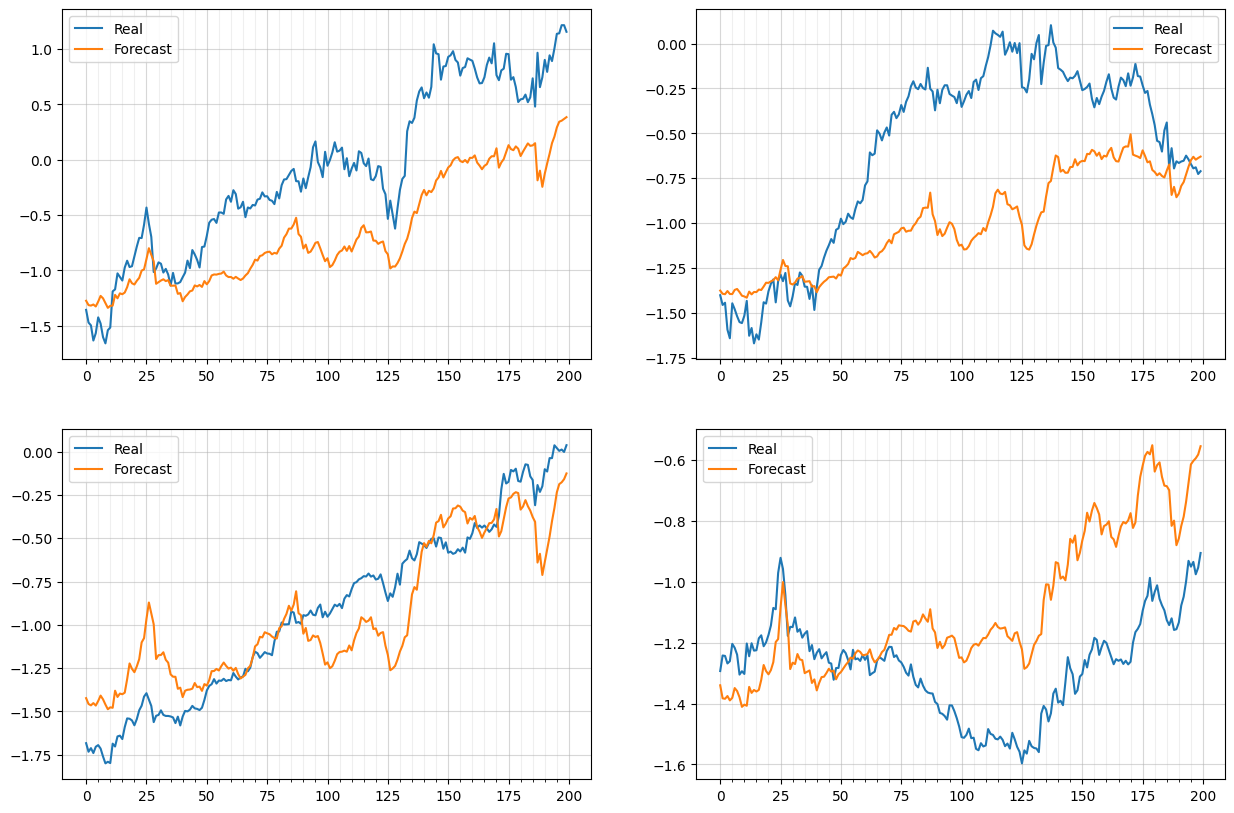

In [33]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
stocks_idx = np.random.choice(train_predictions.shape[1], 4)
n = 200
for idx, stock_idx in enumerate(stocks_idx):
	axs[idx // 2, idx % 2].plot(train_targets[:, stock_idx][n:2 * n], label="Real")
	axs[idx // 2, idx % 2].plot(train_predictions[:, stock_idx][n:2 * n], label="Forecast")
	axs[idx // 2, idx % 2].legend()
	axs[idx // 2, idx % 2].set_xticks(range(0, n, 5), minor=True)
	axs[idx // 2, idx % 2].grid(which='minor', alpha=0.2)
	axs[idx // 2, idx % 2].grid(which='major', alpha=0.5)

plt.show()

### Results on test data

In [34]:
test_predictions = np.array([
	model(g.x, g.edge_index, g.edge_weight).detach().numpy() for g in test_dataloader
]).reshape((len(test_dataloader) * test_dataloader.batch_size, -1))
test_targets = np.array([g.y.numpy() for g in test_dataloader]).reshape((len(test_dataloader) * test_dataloader.batch_size, -1))

MSE = np.mean((test_predictions - test_targets)**2)
RMSE = np.sqrt(MSE)
MAE = np.mean(np.abs(test_predictions - test_targets))

print(f"Mean Squared Error: {MSE:.4f}, Root Mean Squared Error: {RMSE:.4f}, Mean Absolute Error: {MAE:.4f}")

Mean Squared Error: 0.7860, Root Mean Squared Error: 0.8866, Mean Absolute Error: 0.7032


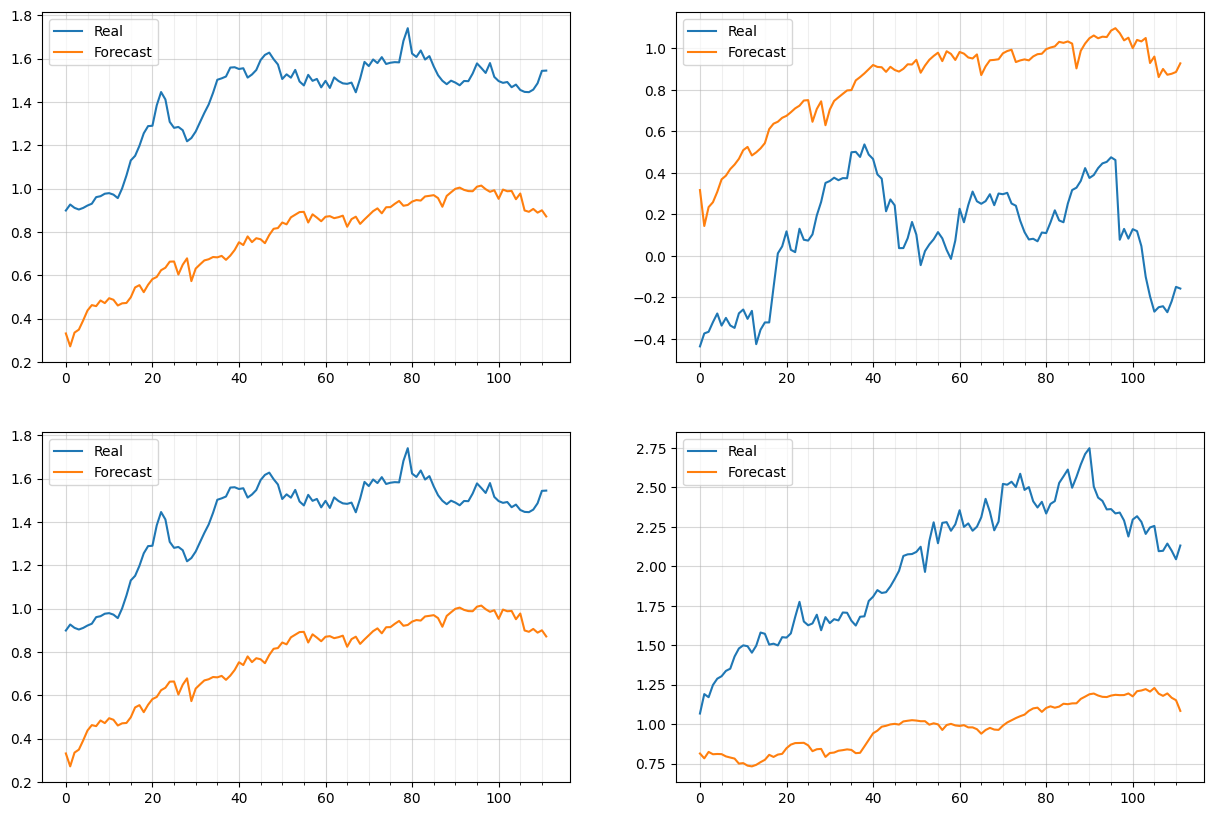

In [35]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
stocks_idx = np.random.choice(test_targets.shape[1], 4)
for idx, stock_idx in enumerate(stocks_idx):
	axs[idx // 2, idx % 2].plot(test_targets[:, stock_idx], label="Real")
	axs[idx // 2, idx % 2].plot(test_predictions[:, stock_idx], label="Forecast")
	axs[idx // 2, idx % 2].legend()
	axs[idx // 2, idx % 2].set_xticks(range(0, len(test_dataloader) * test_dataloader.batch_size, 5), minor=True)
	axs[idx // 2, idx % 2].grid(which='minor', alpha=0.2)
	axs[idx // 2, idx % 2].grid(which='major', alpha=0.5)
	
plt.show()